In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)


from plotting import plot_utils, load_fits
from utils import roi_utils, default_paths, stats_utils, prf_utils

import pandas as pd
import statsmodels.stats.anova
import scipy.stats
import statsmodels.stats.multitest
import copy


#### run this cell to compute pRF coverage maps

In [3]:
from analyze_fits import analyze_prfs
fitting_type = 'gabor_solo_ridge_12ori_8sf_fit_pRFs'
analyze_prfs.compute_prf_coverage(subjects, fitting_type=fitting_type, \
                                  ignore_overlapping_voxels=True, image_size=100)

proc S1, V1: 1688 vox
proc S1, V2: 1554 vox
proc S1, V3: 1349 vox
proc S1, hV4: 485 vox
proc S1, V3ab: 272 vox
proc S1, IPS: 625 vox
proc S1, OPA: 1178 vox
proc S1, PPA: 714 vox
proc S1, RSC: 329 vox
proc S1, OFA: 268 vox
proc S1, FFA: 545 vox
proc S1, EBA: 1959 vox
proc S2, V1: 1235 vox
proc S2, V2: 1035 vox
proc S2, V3: 1095 vox
proc S2, hV4: 398 vox
proc S2, V3ab: 276 vox
proc S2, IPS: 883 vox
proc S2, OPA: 1102 vox
proc S2, PPA: 778 vox
proc S2, RSC: 686 vox
proc S2, OFA: 307 vox
proc S2, FFA: 591 vox
proc S2, EBA: 2049 vox
proc S3, V1: 1392 vox
proc S3, V2: 1123 vox
proc S3, V3: 950 vox
proc S3, hV4: 277 vox
proc S3, V3ab: 307 vox
proc S3, IPS: 527 vox
proc S3, OPA: 808 vox
proc S3, PPA: 741 vox
proc S3, RSC: 350 vox
proc S3, OFA: 498 vox
proc S3, FFA: 477 vox
proc S3, EBA: 1458 vox
proc S4, V1: 961 vox
proc S4, V2: 888 vox
proc S4, V3: 772 vox
proc S4, hV4: 262 vox
proc S4, V3ab: 150 vox
proc S4, IPS: 248 vox
proc S4, OPA: 704 vox
proc S4, PPA: 600 vox
proc S4, RSC: 515 vox
proc 

### load the prf coverage maps, computed in analyze_prfs.py

In [4]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf_fit_pRFs'

roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

fn = os.path.join(default_paths.save_fits_path, 'prf_coverage', \
                  'All_pRFs_%s_no_roi_overlap_100pix.npy'%fitting_type)

prf_coverage = np.load(fn, allow_pickle=True).item()
image_size = prf_coverage['all_mean_prfs'].shape[0]

### plot visual field coverage, averaging all subjects

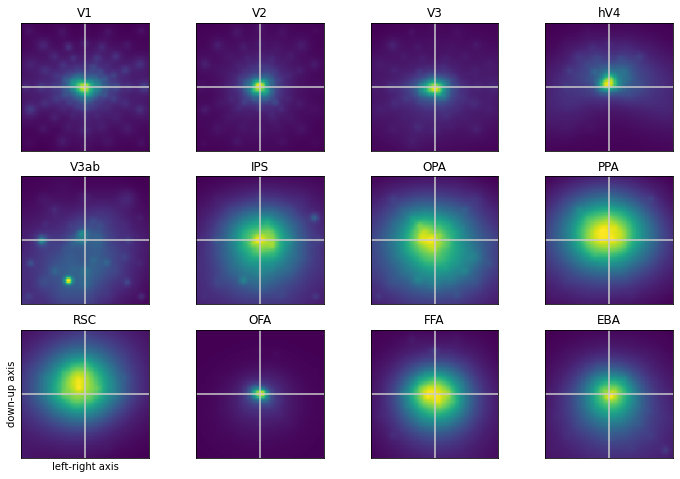

In [5]:
all_comb_prfs = copy.deepcopy(prf_coverage['all_mean_prfs'])
mean_allsubs = np.mean(all_comb_prfs[:,:,:,:], axis=3)

plt.figure(figsize=(12,8));

for rr in range(n_rois):

    plt.subplot(3,4,rr+1)

    plt.pcolormesh(mean_allsubs[:,:,rr])

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axvline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.axhline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.xticks([])
    plt.yticks([])
    
    if rr==8:
        plt.xlabel('left-right axis')
        plt.ylabel('down-up axis')

    plt.title('%s'%roi_names[rr])
    

### make a plot for one ROI at a time (for saving)

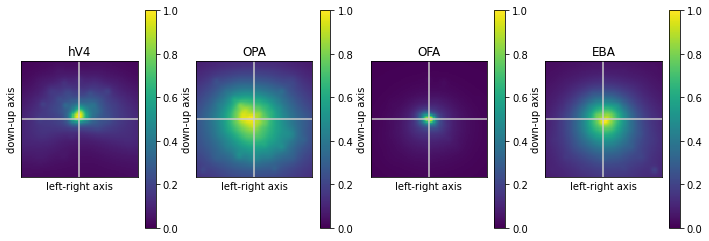

In [7]:
plt.rcParams['pdf.fonttype']=42
rr2plot = [3, 6, 9, 11]
# rr2plot = [3,6,11]

all_comb_prfs = copy.deepcopy(prf_coverage['all_mean_prfs'])
mean_allsubs = np.mean(all_comb_prfs[:,:,:,:], axis=3)

rr = 6
plt.figure(figsize=(12,4))

for ri, rr in enumerate(rr2plot):

    plt.subplot(1,4,ri+1)
    meanvals = mean_allsubs[:,:,rr]/np.max(mean_allsubs[:,:,rr])
    plt.pcolormesh(meanvals, vmin=0, vmax=1)

    plt.axis('square')
    plt.gca().invert_yaxis()
    plt.axvline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.axhline(image_size/2, color=[0.8, 0.8, 0.8])
    plt.xticks([])
    plt.yticks([])
    minval=np.min(mean_allsubs[:,:,rr])
    maxval=np.max(mean_allsubs[:,:,rr])
    plt.colorbar()
    # cbar =plt.colorbar(ticks=np.linspace(minval,maxval,5))
    # cbar.ax.set_yticklabels(['%.1e'%tt for tt in np.linspace(minval,maxval,5)])

    plt.xlabel('left-right axis')
    plt.ylabel('down-up axis')

    plt.title('%s'%roi_names[rr])

fn2save = os.path.join(default_paths.fig_path,'Avg_pRF_coverage_selectedrois_gaborfits.pdf')
plt.savefig(fn2save)

## Now compare the pRF coverage across quadrants of visual field

### 3-way RM anova (ROI x horizontal x vertical)

In [9]:
all_comb_prfs = prf_coverage['all_mean_prfs']
# all_comb_prfs /= np.max(np.max(all_comb_prfs, axis=0), axis=0)

image_size = all_comb_prfs.shape[0]

# compute avg values in each vis field quadrant
center = int(all_comb_prfs.shape[0]/2)
mean_ul = np.mean(np.mean(all_comb_prfs[0:center,0:center,:,:], axis=0), axis=0)
mean_ll = np.mean(np.mean(all_comb_prfs[center:,0:center,:,:], axis=0), axis=0)
mean_ur = np.mean(np.mean(all_comb_prfs[0:center,center:,:,:], axis=0), axis=0)
mean_lr = np.mean(np.mean(all_comb_prfs[center:,center:,:,:], axis=0), axis=0)

mean_each_quad = np.concatenate([mean_ul[:,:,np.newaxis], \
                                 mean_ur[:,:,np.newaxis], \
                                 mean_ll[:,:,np.newaxis], \
                                 mean_lr[:,:,np.newaxis]], axis=2)
quad_names = ['upper left', 'upper right','lower left', 'lower right']

prf_df = pd.DataFrame(data={'subject': np.repeat(np.arange(n_subjects), n_rois*2*2), \
                           'roi': np.tile(np.repeat(np.arange(n_rois), 2*2),[n_subjects,]), \
                           'vert': np.tile(np.repeat(np.arange(2), 2), [n_subjects*n_rois,]), \
                           'horiz': np.tile(np.arange(2), [n_subjects*n_rois*2,])})

prf_values = np.zeros((n_subjects*n_rois*2*2))
for si in range(n_subjects):
    for rr in range(n_rois):
        inds = (prf_df['subject']==si) & (prf_df['roi']==rr)
        prf_values[inds] = mean_each_quad[rr,si,:]
prf_df['prf_values'] = prf_values

model = statsmodels.stats.anova.AnovaRM(data=prf_df, \
                                        depvar='prf_values', \
                                        subject='subject', \
                                        within = ['roi', 'vert', 'horiz'])
rm_result = model.fit()
print(rm_result)

                    Anova
               F Value  Num DF  Den DF Pr > F
---------------------------------------------
roi               -inf 11.0000 77.0000 1.0000
vert           12.5861  1.0000  7.0000 0.0094
horiz           0.2666  1.0000  7.0000 0.6215
roi:vert       15.2987 11.0000 77.0000 0.0000
roi:horiz       1.8466 11.0000 77.0000 0.0603
vert:horiz      0.7129  1.0000  7.0000 0.4264
roi:vert:horiz  3.3620 11.0000 77.0000 0.0008



/home/mmhender/myenv/lib/python3.7/site-packages/statsmodels/stats/anova.py:602: RuntimeWarning: divide by zero encountered in double_scalars
  F = msm / mse


In [10]:
anova_table = pd.DataFrame(rm_result.anova_table)
anova_table.iloc[:,0] = anova_table.iloc[:,0].round(3)
anova_table['Num DF'] = anova_table['Num DF'].astype(int)
anova_table['Den DF'] = anova_table['Den DF'].astype(int)
anova_table['Pr > F'].map('${:,.4f}'.format)
# anova_table['Pr > F'] = anova_table.iloc[:,3].round(4)
anova_table

anova_table.to_csv(os.path.join(default_paths.fig_path,'prf_anova_gabormodel.csv'))

### t-tests within ROIs for effect of vertical pos

In [18]:
tstats_vert = np.zeros((n_rois,),dtype=float)
pvals_vert = np.zeros((n_rois,),dtype=float)
pvals_nonpar_vert = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 465655
for rr in range(n_rois):
    
    upper_values = mean_each_quad[rr,:,0:2].ravel()
    lower_values = mean_each_quad[rr,:,2:4].ravel()
    
    stats = scipy.stats.ttest_rel(upper_values, lower_values)
    
    tstats_vert[rr] = stats.statistic
    pvals_vert[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(upper_values, lower_values, \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_vert[rr] = p
    
    subj_diffs = np.mean(mean_each_quad[rr,:,0:2], axis=1) - np.mean(mean_each_quad[rr,:,2:4], axis=1)
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_vert
p_values = pvals_nonpar_vert
orig_shape = p_values.shape
mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), 
                                                                alpha=0.01)
mask_fdr = np.reshape(mask_fdr, orig_shape)
pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
vertical_df = pd.DataFrame({'t-stat for upper>lower': tstats_vert, \
                           'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, 'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
mask_fdr_vert = mask_fdr
vertical_df.round(3)



,t-stat for upper>lower,pvalue_fdr,sig_fdr,n_subs_indiv
V1,-0.302,0.790,False,4
V2,0.407,0.750,False,4
V3,-9.472,0.000,True,8
hV4,4.252,0.000,True,7
V3ab,-5.066,0.000,True,7
IPS,-4.578,0.001,True,7
OPA,-3.640,0.005,True,7
PPA,4.502,0.001,True,7
RSC,4.980,0.001,True,7
OFA,-10.833,0.000,True,8


### t-tests for horizontal (no effects here)

In [26]:
tstats_horiz = np.zeros((n_rois,),dtype=float)
pvals_horiz = np.zeros((n_rois,),dtype=float)
pvals_nonpar_horiz = np.zeros((n_rois,),dtype=float)
n_subs_samedir = np.zeros((n_rois,),dtype=int)

rndseed = 232444
for rr in range(n_rois):
    
    left_values = np.take(mean_each_quad[rr,:,:],[0,2],axis=1)
    right_values = np.take(mean_each_quad[rr,:,:],[1,3],axis=1)
    
    stats = scipy.stats.ttest_rel(left_values.ravel(), right_values.ravel())
    
    tstats_vert[rr] = stats.statistic
    pvals_vert[rr] = stats.pvalue
    
    p, d = stats_utils.paired_ttest_nonpar(left_values.ravel(), right_values.ravel(), \
                                           n_iter=10000, rndseed=rndseed)    
    pvals_nonpar_horiz[rr] = p
    
    subj_diffs = np.mean(left_values, axis=1) - np.mean(right_values, axis=1)
    n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

# p_values = pvals_horiz
p_values = pvals_nonpar_horiz
orig_shape = p_values.shape
mask_fdr, pvals_fdr = statsmodels.stats.multitest.fdrcorrection(p_values.ravel(), alpha=0.01)
mask_fdr = np.reshape(mask_fdr, orig_shape)
pvals_fdr = np.reshape(pvals_fdr, orig_shape)
   
horiz_df = pd.DataFrame({'t-stat for left>right': tstats_horiz, \
                           'pvalue_fdr': pvals_fdr, 'sig_fdr': mask_fdr, 'n_subs_indiv': n_subs_samedir}, \
                          index=roi_names)
mask_fdr_horiz = mask_fdr
horiz_df.round(3)



,t-stat for left>right,pvalue_fdr,sig_fdr,n_subs_indiv
V1,0.0,0.681,False,4
V2,0.0,0.791,False,5
V3,0.0,0.631,False,5
hV4,0.0,0.537,False,6
V3ab,0.0,0.431,False,5
IPS,0.0,0.537,False,6
OPA,0.0,0.286,False,4
PPA,0.0,0.052,False,6
RSC,0.0,0.000,True,7
OFA,0.0,0.546,False,4


### plot the quadrant values for each ROI

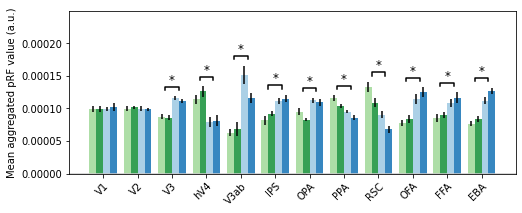

In [27]:
mean_vals = np.mean(mean_each_quad, axis=1)
sem_vals = np.std(mean_each_quad, axis=1)/np.sqrt(n_subjects)

quad_colors = np.concatenate([cm.Greens(np.linspace(0,1,4))[1:3,:], \
                              cm.Blues(np.linspace(0,1,4))[1:3,:]], axis=0)

plt.rcParams['pdf.fonttype']=42
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                space=0.1, \
                xticklabels=roi_names, ylabel='Mean aggregated pRF value (a.u.)', \
                ylim=[0, 0.000250], title='',\
                legend_labels=quad_names, \
                colors = quad_colors, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(8,3),
                add_brackets = mask_fdr_vert, 
                bracket_text = ['*' if mask_fdr_vert[ri] else None for ri in range(n_rois) ])
plt.yticks(np.arange(0,0.00021, 0.00005))

fn2save = os.path.join(default_paths.fig_path,'Quadrant_avg_pRFs_gabormodel.pdf')
plt.savefig(fn2save)